<a href="https://colab.research.google.com/github/codesoumya2006/Birthdaywish_animated_frontend_web/blob/main/recipes/RAG/Granite_Multimodal_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o.

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Install dependencies.

In [23]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install git+https://github.com/ibm-granite-community/utils.git \
    transformers \
    pillow \
    langchain_classic \
    langchain_core \
    langchain_huggingface sentence_transformers \
    langchain_milvus 'pymilvus[milvus_lite]' \
    docling \
    'langchain_replicate @ git+https://github.com/ibm-granite-community/langchain-replicate.git'
! echo "::endgroup::"

::group::Install Dependencies
Using Python 3.12.12 environment at: /usr
Resolved 140 packages in 477ms
Audited 140 packages in 3ms
::endgroup::


## Step 2: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [24]:
import logging

logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [25]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

Specify the MLLM to use for image understanding. We will use the Granite vision model.

In [26]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_replicate import Replicate
from transformers import AutoProcessor

vision_model_path = "ibm-granite/granite-vision-3.3-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

Specify the language model to use for the RAG generation operation. Here we use the Replicate LangChain client to connect to a Granite model from the [`ibm-granite`](https://replicate.com/ibm-granite) org on Replicate.

To get set up with Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).

To connect to a model on a provider other than Replicate, substitute this code cell with one from the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [27]:
from langchain_replicate import ChatReplicate

model_path = "ibm-granite/granite-4.0-h-small"
model = ChatReplicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)

## Step 3: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [28]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
]
conversions = { source: converter.convert(source=source).document for source in sources }

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [29]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


#/texts/1
#/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11 #/texts/12 #/texts/13
#/tables/0 #/texts/16 #/texts/17 #/texts/18
#/texts/21
#/texts/23
#/texts/25
#/texts/27
#/texts/29
#/texts/31
#/texts/33
#/texts/35 #/texts/38 #/texts/39 #/texts/40 #/texts/41
#/texts/45 #/texts/46
#/texts/48 #/texts/49 #/texts/50 #/texts/51 #/texts/52 #/texts/53 #/texts/54 #/texts/55 #/texts/56 #/texts/57
#/texts/59 #/texts/60 #/texts/61 #/texts/62 #/texts/63 #/texts/64 #/texts/65
#/texts/141
#/tables/1 #/texts/145 #/texts/153
#/texts/157 #/texts/158
#/texts/160 #/texts/161 #/texts/162
#/texts/166 #/texts/167 #/texts/168 #/texts/169
#/texts/182
#/texts/184 #/texts/185 #/texts/186 #/texts/187 #/texts/188 #/texts/189 #/texts/190
#/texts/193
#/texts/195
#/texts/197
#/texts/199
#/texts/201
#/texts/203
#/texts/205
#/texts/207
#/texts/209
#/texts/211
#/texts/213
#/texts/215
#/texts/217
#/texts/225 #/texts/226 #/texts/227
#/texts/229 #/texts/230
#/texts/232
#/texts/235 #/texts/23

Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [30]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown(docling_document)
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)


print(f"{len(tables)} table documents created")

#/tables/1
1 table documents created


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

In [39]:
import base64
import io
import PIL.Image
import PIL.ImageOps
from ibm_granite_community.langchain.prompts import TokenizerChatPromptTemplate
from langchain_core.messages import HumanMessage
from replicate.exceptions import ReplicateError
import time

def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Feel free to experiment with this prompt
image_prompt = "If the image contains text, explain the text in the image."
vision_prompt_template = TokenizerChatPromptTemplate.from_messages(
    messages=[
        HumanMessage(content=[
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ]),
    ],
    tokenizer=vision_processor)
vision_prompt = vision_prompt_template.format_prompt()

# Function to process image with retry logic
def process_image_with_retry(vision_model, vision_prompt, image_encoded, max_retries=5, delay=10):
    for attempt in range(max_retries):
        try:
            text = vision_model.invoke(vision_prompt, images=[image_encoded])
            return text
        except ReplicateError as e:
            if "status: 429" in str(e): # Check for rate limit error specifically
                print(f"Rate limit hit. Retrying in {delay} seconds... (Attempt {attempt + 1}/{max_retries})")
                time.sleep(delay)
            else:
                raise e # Re-raise other ReplicateErrors
    raise ReplicateError(f"Failed to process image after {max_retries} attempts due to persistent rate limits.")

pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        if image:
            encoded_image = encode_image(image)
            try:
                text = process_image_with_retry(vision_model, vision_prompt, encoded_image)
                document = Document(
                    page_content=text,
                    metadata={
                        "doc_id": (doc_id:=doc_id+1),
                        "source": source,
                        "ref": ref,
                    },
                )
                pictures.append(document)
            except ReplicateError as e:
                print(f"Skipping image {ref} due to persistent Replicate error: {e}")


print(f"{len(pictures)} image descriptions created")

#/pictures/0
#/pictures/1
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/2
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/3
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/4
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/5
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/6
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/7
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/8
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/9
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/10
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/11
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/12
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/13
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/14
Rate limit hit. Retrying in 10 seconds... (Attempt 1/5)
#/pictures/15
Ra

We can then display the LangChain documents created from the input documents.

Document ID: 1
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
bridging the gap between poverty and prosperity
Document ID: 2
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape.
All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines.  To  allow  partner agencies to receive food from MFB safely, we altered our distribution model.  Community,  business,  and  donor  support  funded  operations and helped with food purchases. More details on our response to the pandemic are on page 14.
Noteworthy in 2020:
- MFB distributed a record amount of food, 37% more than 

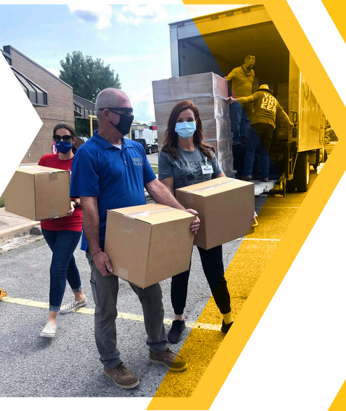

Document ID: 75
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "Midwest Food Bank." This text is part of the logo design, which is intended to represent the organization's identity. The Midwest Food Bank is a nonprofit organization that operates in the Midwest region of the United States. It is known for its role in providing food assistance to those in need. The logo's design uses the wheat stalk, which is a symbol commonly associated with agriculture and food production, to visually represent the organization's focus on food banking.
Image:


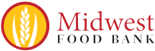

Document ID: 76
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a motivational message, "KEEP MOVING FORWARD". This phrase is commonly used to encourage perseverance and progress, especially in the context of personal development, goal setting, or overcoming challenges. It is a positive and action-oriented message that can be applied in various life situations, such as in sports, education, career, or personal growth. The repetition of "KEEP MOVING FORWARD" emphasizes the importance of continuous action and progress.
Image:


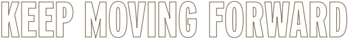

Document ID: 77
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be part of the logo and is not fully legible. It is stylized with a geometric design that could be a signature of the brand or entity it represents. The text is in a bold, sans-serif font, which is common in modern branding for its clean and professional appearance. Without clearer text, it's not possible to provide a transcription or translation of the text. If the text is intended to convey specific information, it would typically be placed in a clear, readable format, either on a separate label or as part of a larger textual message.
Image:


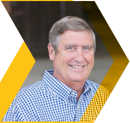

Document ID: 78
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully visible; only a small portion of a yellow hexagon with a black text is shown. The text appears to be part of a larger message, but without the complete text, it's not possible to provide an accurate transcription or interpretation. If the text is intended to convey a message about the image, such as "Community Service" or "Volunteer at the Food Bank," it would be reasonable to deduce that the image is meant to represent the importance of community service and the role of volunteers in providing assistance to those in need.
Image:


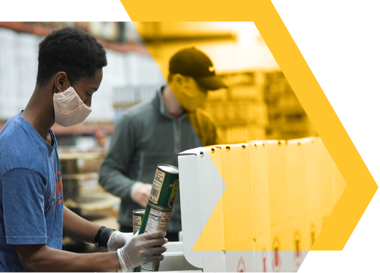

Document ID: 79
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "GROWMARK", which is likely a brand or company name. It's designed in a bold, sans-serif font, which is commonly used for its clear readability and modern appearance. The text is in all caps, which can be a stylistic choice to emphasize the brand name or to make it stand out against the background. Without additional context, it's not possible to determine the specific nature of the brand or the products or services it may offer.
Image:


Document ID: 80
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the low resolution. The icons represent different social media platforms, which are commonly used for networking, communication, and sharing content online. The Facebook icon is a square with a blue background and white lettering. The Instagram icon is a square with a vibrant background of purple and pink, featuring a camera lens icon. The LinkedIn icon is a square with a blue background and white lettering. These icons are used to represent the respective platforms on various digital interfaces.
Image:


Document ID: 81
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the overlay of the yellow hexagon. However, it appears to be the name of the organization involved in the activity, which is "Midwest Food Bank." The text is likely part of a branding or awareness campaign, as it is placed in a prominent position and styled differently from the background. The text serves to identify the organization and its involvement in the image, which is consistent with the purpose of such images used for publicity and educational outreach.
Image:


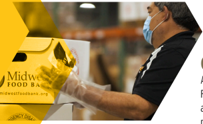

Document ID: 82
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text. It is a simple icon representing the concept of a handshake. Handshake icons are commonly used in user interfaces to represent the action of greeting, agreement, or the initiation of a transaction. They can be found in various applications, from websites and mobile apps to software programs, to indicate the user's willingness to engage in a collaborative or business-related activity. The absence of text in this image means that the icon's meaning is universally understood and does not require any additional explanation.
Image:


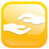

Document ID: 83
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not present. The image is a graphic symbol, and it does not contain any text that can be read or translated. It is a simplified icon that represents a person with outstretched arms, which is commonly used in various digital applications to symbolize a range of concepts from celebration, victory, or a positive message to the concept of spreading or sharing something. Without additional context, it's not possible to provide a more detailed interpretation of the text.
Image:


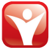

Document ID: 84
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible. The image is a graphical icon with no text present. If there were text, it would be described in terms of its content, size, color, and any distinctive features such as font or style. Since the image contains no text, no such description is applicable. If the image is intended to convey text, it should be mentioned that it is not possible to read or interpret the text from the image. This is important for maintaining objectivity and avoiding assumptions about the content of images that may not be present.
Image:


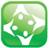

Document ID: 85
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains a text that is part of a shield icon, which is commonly used to represent security, protection, or a private setting. The text is not fully legible due to the resolution of the image. However, if we were to infer from the visible portion, it could be a brand name, a service, or a message associated with security and privacy. Without clearer text, it is not possible to provide a precise interpretation of the message. If the text is important, it would be best to view the image in a higher resolution or with a clearer display to ensure accurate understanding.
Image:


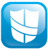

Document ID: 86
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not readable due to the resolution and size of the text. It appears to be a form of textual content that is typically found in digital documents or websites, intended to convey information. Without a clearer image or additional context, it is not possible to provide a precise interpretation of the text. If the text is crucial for understanding the image, a higher resolution image or a clearer text version would be necessary to give an accurate explanation. It is important to note that any attempt to read or interpret text in images that are not clear would be speculative and not in line with professional or ethical standards.
Image:


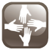

Document ID: 87
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image is not legible due to the resolution and the image's quality. It appears to be a label on one of the cardboard boxes, but the specific details of the text cannot be discerned from the current image. If the text is important for understanding the context or message, it would be necessary to have a clearer image or additional information to accurately interpret the text. Without this, any attempt to describe the text would be speculative and potentially misleading.
Image:


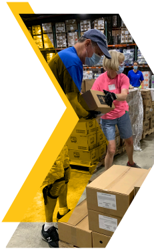

Document ID: 88
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "FOOD INSECURITY." This term refers to a situation where individuals or communities lack access to sufficient, safe, and nutritious food. It is a significant issue that affects many parts of the world, with implications for health, well-being, and overall quality of life. The image serves as a visual reminder of the importance of addressing food insecurity, which can be tackled through various strategies such as improving agricultural practices, reducing food waste, and ensuring equitable access to food resources.
Image:


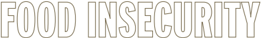

Document ID: 89
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be "Your pass". This suggests that the image might be related to a service or product that involves passports or travel, possibly a travel company or a service that handles passports. The text is placed in a way that it does not interfere with the main subject of the photograph, which is the smiling woman. Without additional context, it is not possible to determine the exact nature of the text or its full message.
Image:


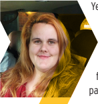

Document ID: 90
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not fully legible. It appears to be a fragment of a sentence, with the visible letters "ban" and "Hope." Given the incomplete text, it is impossible to provide a full and accurate transcription or interpretation of the message. If the text is intended to convey a message or provide context, it would be beneficial to have the full text to ensure proper understanding. Without the complete text, any attempt to interpret the message would be speculative and not reliable.
Image:


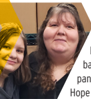

Document ID: 91
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and only a portion is visible. It appears to be the beginning of a word or phrase that starts with "I'm" and ends with "up," which suggests the text might be part of a larger message or statement. Due to the obscured text, it's not possible to provide the full context or meaning of the message. If the text is intended to be readable, it might be part of a larger message or could be an incomplete thought or quote. Without the full visibility of the text, any attempt to provide more information would be speculative.
Image:


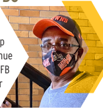

Document ID: 92
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be "BERLINDA," which could be a proper noun, such as a name, place, or brand. Without additional context, it's not possible to determine the exact meaning or relevance of this text. It is placed in a way that it doesn't interact with the main subject of the photograph, which is the woman. The text's presence seems to be more decorative than functional, possibly indicating a brand, a personal statement, or a slogan. The style of the text, along with the image, suggests that it might be used for branding or as a form of artistic expression.
Image:


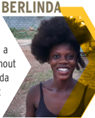

Document ID: 93
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "Donations MFB Programs." This indicates that the image is likely an infographic or a visual aid designed to inform about the various programs that are part of the MFB (Mebou Faso Bourgou) initiative. MFB is an acronym for Médecins Sans Frontières, a humanitarian organization known for providing medical aid where it is needed most. The image suggests that MFB programs are supported by donations, which are then used to fund various aspects of their work, including food and disaster relief, tender mercy, and hope packs.
Image:


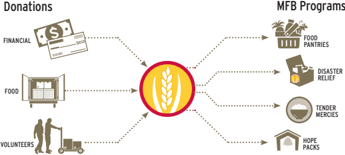

Document ID: 94
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be a caption for a graph that is not fully visible. It seems to be discussing the growth in the number of Midwest Food Bank locations and the value of food distributed. The specific details of the text, including the exact numbers and the year it refers to, cannot be determined from the given image. The caption implies that the data is intended to inform about the progress or changes in the Midwest Food Bank's operations, specifically in terms of the expansion of its facilities and the increase in the volume of food it handles.
Image:


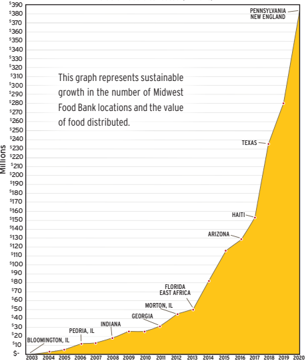

Document ID: 95
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image states that "13 MILLION SPENT YIELDS $383 MILLION FOOD DISTRIBUTED". This message suggests a comparison of expenditure and the resulting yield or impact of that expenditure, specifically in terms of food distributed. The text implies that for every dollar spent, $383 is distributed in the form of food. This could be part of a campaign or initiative aimed at addressing food distribution issues, possibly in the context of a specific event or organization.
Image:


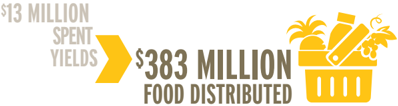

Document ID: 96
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image, which is not fully visible, seems to be related to the branding or labeling of the products inside the cardboard boxes. The visible text includes "Baby Speach," which could be a brand name or a product line. Due to the image's resolution and the text's small size, it's not possible to provide a detailed transcription of the text. If you need specific information about the text, it would be best to refer to the original source or context where the image is being used, as it may provide more accurate and detailed information about the text.
Image:


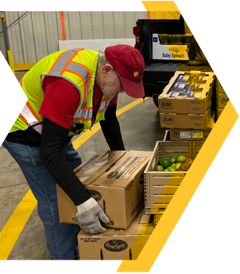

Document ID: 97
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is primarily the branding of the Midwest Food Bank, which is a well-known organization in the United States. The text on the boxes is partially obscured, but it is clear that it includes the organization's name, "Midwest Food Bank," along with a tagline that reads, "Sharing the Blessings." This tagline is part of the organization's mission statement, which is to provide food assistance to those in need. The text is designed to be eye-catching and informative, aiming to raise awareness about the organization's cause and its services.
Image:


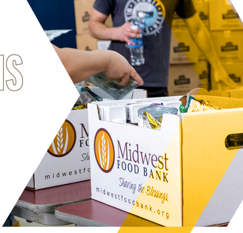

Document ID: 98
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be a mix of incomplete phrases and what looks like a command or instruction. It reads: "Tender or by vo". Without additional context, it's difficult to determine the full meaning or intent behind this text. It could be a part of a larger message or a command that is incomplete. It's important to note that any interpretation of text from images should be made with the understanding that images can be used to convey a wide range of messages and meanings, and it's not always possible to determine the intended message without more information.
Image:


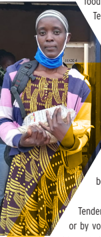

Document ID: 99
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that is not fully legible due to the low resolution and small size. However, from what can be discerned, it appears to be a comparison between the year 2019 and 2020, possibly showing changes in international and domestic data. The exact numbers and context of the text are not clear from the image. If you have a clearer image or additional details, I would be happy to provide a more detailed analysis. Otherwise, it's challenging to accurately describe the text in this image.
Image:


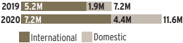

Document ID: 100
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be "S" on the left side, which could be part of a larger word or phrase. Given the context of the image, which seems to be centered around a child enjoying a meal, the text might be related to the branding or the title of a campaign or product that promotes healthy eating habits, especially for children. Without the full text, it is not possible to determine the exact message or brand. If this is a part of a larger text, it might be used in a context that encourages nutritional awareness or the importance of balanced diets.
Image:


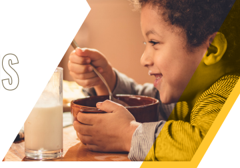

Document ID: 101
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "A" which is a letter from the English alphabet. It is written in a simple, sans-serif font and is colored yellow. The text is centered and stands out against the white background of the image. There is no additional text or context provided within the image, so it is not possible to determine what "A" represents beyond the letter itself. If this image is part of a larger text or sequence, it would be necessary to have more context to provide a detailed explanation.
Image:


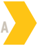

Document ID: 102
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a label that identifies the location of a remote distribution site in Arizona, specifically in Gilbert, Arizona. This label is likely used to denote a specific point of interest on a map, possibly for logistical or administrative purposes. The text is clear and legible, with no additional context provided within the image that would necessitate further interpretation of the text. The label serves as a geographical marker for the remote distribution site, which could be relevant for various applications such as delivery services, resource management, or emergency services.
Image:


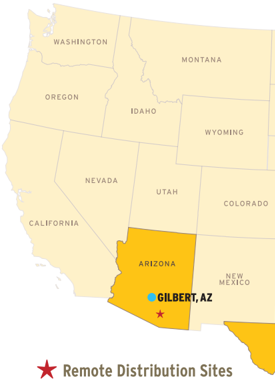

Document ID: 103
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "KENYA," which is written in capital letters and is located on the upper left side of the map. The text is in a simple, sans-serif font and is colored to stand out against the yellow background of the map. It is used to label the country that the map represents. The text is clear and legible, making it the most prominent textual element on the image. There is no additional text present that can be described. The text is integral to the image as it identifies the geographical area being referenced, which in this case is Kenya.
Image:


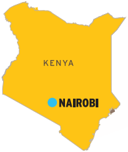

Document ID: 104
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image refers to the locations of the Midwest Food Bank, which is a nonprofit organization that provides food assistance to low-income individuals and families. The image shows that the Midwest Food Bank has a domestic presence in 10 states and 2 international locations. The domestic locations are marked with yellow pins on a map of the United States, and the international locations are indicated by a world map with pins in Haiti and Cape Verde. The text "MIDWEST FOOD BANK 2 INTERNATIONAL LOCATIONS" is also present, suggesting that the organization has a global reach beyond the United States. The image is likely used for educational or informational purposes, to inform viewers about the locations of the Midwest Food Bank and its international outreach.
Image:


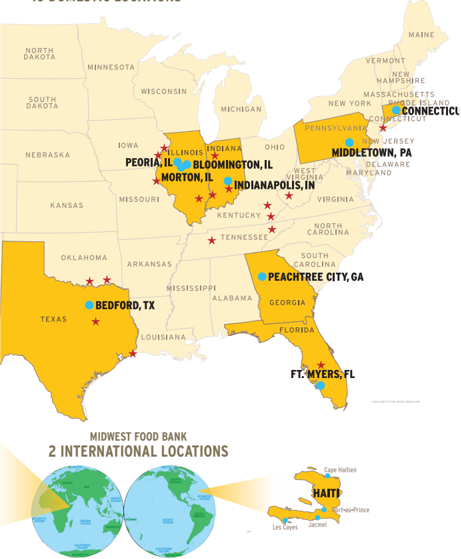

Document ID: 105
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the resolution and size of the text. Without a clearer image or the ability to enlarge the text, it is not possible to accurately describe or transcribe the text. If the text is meant to convey a message or provide information, it would be appropriate to request a clearer image or provide the text directly for analysis. In this case, it is not possible to fulfill the request as it stands. For any text analysis, a clear and legible image is necessary.
Image:


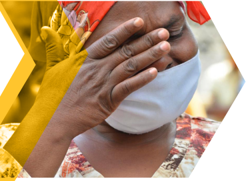

Document ID: 106
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not entirely legible due to the resolution and angle of the photograph. However, it appears to be a message or statement, possibly related to the event or cause being depicted. Without a clearer image or additional context, it is not possible to provide a precise transcription or interpretation of the text. If the text is important, it would be advisable to seek out the source of the image or the event being depicted for a more accurate understanding of the message.
Image:


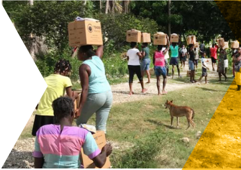

Document ID: 107
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the low resolution and the overlay of the yellow hexagon shape. The image focuses on the individuals and their actions rather than any text present. If the text were clear and legible, it would typically provide information about the event, the organization involved, the purpose of the activity, or safety guidelines related to the task at hand. Without the ability to read the text, we cannot provide specific details about it. However, it is reasonable to infer that the text might be informative, given the context of a military setting and the organized activity.
Image:


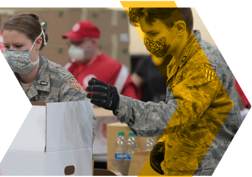

Document ID: 108
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible in the provided photograph. It is rendered in a yellow color that stands out against the background, but without a clearer image or additional context, it is impossible to accurately describe or transcribe the text. If you have a higher resolution image or a clearer text, I would be able to assist with transcription and interpretation. Otherwise, I must refrain from making speculative statements about the content of the text. It is important to respect privacy and confidentiality, especially regarding images that may contain personal information.
Image:


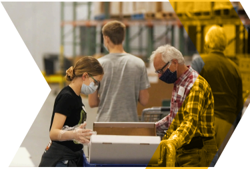

Document ID: 109
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a statement about the number of volunteers in relation to paid staff members in a certain year. It reads, "IN 2020, THERE WERE 450 VOLUNTEERS FOR EVERY 1 PAID MFB STAFF MEMBER." This suggests that for every one paid member of a certain staff, there were 450 volunteers. The acronym "MFB" is not defined in the image, so it is unclear what it stands for. Without additional context, it is not possible to determine the specific organization or entity this statement pertains to.
Image:


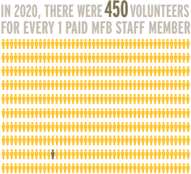

Document ID: 110
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is part of a larger message that is not fully visible. However, from what is shown, we can deduce that the text is likely to be related to the organization's mission or a message of kindness and support, given the context of the image. The visible text reads "Midwest Food Bank," which is the name of the organization, and the phrase "more and better than our competitors" suggests a comparison of service quality or impact. The incomplete text at the bottom of the image does not provide enough information to be accurately described. If the text is incomplete, it may be part of a larger message or slogan that is not fully displayed in the image.
Image:


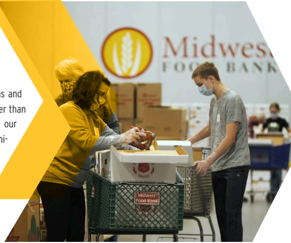

Document ID: 111
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads as follows:
- At the top of the image, it says "MIDWEST FOOD BANK DISASTER RELIEF LOADS IN 2020."
- Inside the box, the text reads "DOING THE MOST GOOD."
- At the bottom of the image, it says "MIDWEST FOOD BANK LOCATIONS."

This text provides information about the Midwest Food Bank's efforts in disaster relief during the year 2020, emphasizing their commitment to providing aid. The box is likely a symbol of the food bank's relief efforts, with the message "DOING THE MOST GOOD" being a slogan that conveys their philanthropic purpose. The "MIDWEST FOOD BANK LOCATIONS" text indicates the geographical reach of the organization.
Image:


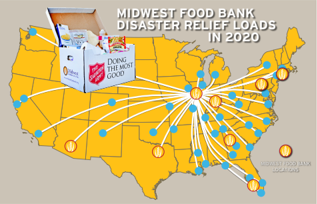

Document ID: 112
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not present; it is a graphic representation of a smartphone. The symbol on the screen is commonly used to represent mobile phone connectivity, indicating that the phone is either searching for a network signal, has a strong connection, or is experiencing poor signal strength. The use of such a symbol is universal and is intended to be easily recognizable, regardless of language barriers, to communicate the concept of mobile phone connectivity. The image does not contain any text that requires translation or interpretation.
Image:


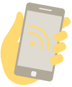

Document ID: 113
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be an incomplete sentence or statement. The visible portion reads "In addi Midwest." It is not possible to provide a full transcription of the text due to the incomplete visibility of the text. If the full text is required, it would be necessary to have the complete image or additional context to accurately transcribe and interpret the message. In scenarios like this, it is important to respect privacy and not make assumptions about the content of the text, especially when it involves personal or sensitive information.
Image:


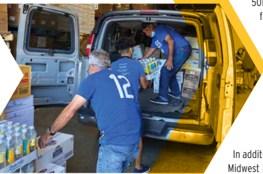

Document ID: 114
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured; however, it appears to be a stylized representation of the word "MAT" with a yellow background. It's not possible to provide a full transcription of the text as it is not fully visible. The text is likely part of a larger piece of content, possibly a brand name, a title, or a slogan, given the prominent and stylized presentation. Without additional context or a clearer view, it is not feasible to provide a detailed analysis or interpretation of the text.
Image:


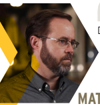

Document ID: 115
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text on the side of the truck is partially obscured, but it appears to be a brand or company name. Due to the resolution and the angle of the photograph, the full text cannot be read with certainty. It is common for trucks to display the company's logo or name, which serves as a form of branding. This text is essential for identifying the company that owns the truck and is likely used for marketing and logistical purposes. If the text is important for a specific purpose, it would be best to consult the company directly for accurate information.
Image:


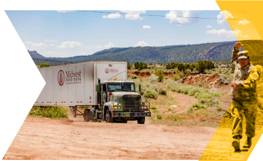

Document ID: 116
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it seems to relate to a breakdown of donations or contributions in a community or organizational setting. The visible text includes "5% Other Local Grocery Runs, Food Drives, Other Donations," which suggests that the pie chart is showing the distribution of donations or contributions to various entities. The specific entities listed, such as "USDA Food Boxes," "Food Distributors," and "Food Manufacturers," indicate that the chart is categorizing donations into different sectors of the food industry. The percentages likely represent the proportion of total donations allocated to each category.
Image:


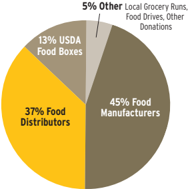

Document ID: 117
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "MFB distributed over $52 million." This indicates that the Maryland Football Club has distributed a sum of $52 million. Without additional context, it is not possible to determine the specific nature of the distribution, whether it pertains to a sports event, a fundraising campaign, or another purpose. The image alone does not provide information on the entities involved, the timeframe, or the purpose behind the distribution of the funds.
Image:


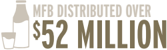

Document ID: 118
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that is not fully legible. It appears to be a comparison of percentages for the years 2019 and 2020, specifically for "Dairy, Produce, and Protein." However, the exact numbers and the full context of the text are not clear from the image provided. To accurately interpret the text, one would need a clearer or higher resolution image of the text. If the text is part of a larger document or presentation, it would be helpful to have access to the full content to provide a precise answer.
Image:


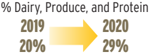

Document ID: 119
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image is on the labels of the dairy products. It includes the brand name "Prairie Farms," which is written in a large, bold font on the yellow carton and the label of the cream cheese. The text on the blue carton of milk is partially obscured, but it includes the number "2" and the brand name "Prairie Farms," indicating that it is a 2% milk product. The text on the cream cheese container is not fully legible, but it appears to include the brand name "Prairie Farms" and possibly some nutritional information or product details. The text on the box of chocolate milk is also not fully visible, but it includes the brand name "Prairie Farms" and some images of the product. The text is clear and serves to identify the brand and product type, which is essential for consumers to make informed purchasing decisions.
Image:


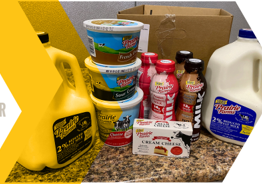

Document ID: 120
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that is partially obscured. It appears to be discussing the comparative organizations and their total program services and management, general, and fundraising expenses. The text is not fully legible, but it seems to be highlighting a comparison between different organizations, possibly in terms of their financial performance or resource allocation. The exact details of the text cannot be accurately determined from the image provided. If you need a more detailed analysis or specific information from the text, it would be best to consult the original source or a clearer image.
Image:


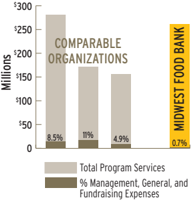

Document ID: 121
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads as follows: "Midwest Food Bank" is written in a large, serif typeface at the top of the image. Directly below it, in a smaller, sans-serif font, is the phrase "SHARE PARTNERS." This text is part of the branding for the Midwest Food Bank, which is likely a non-profit organization that operates a food bank, as indicated by the text. The presence of the wheat stalk in the logo reinforces the organization's focus on food and agriculture. The text serves to identify the organization and its mission, which is to provide food and share it with those in need.
Image:


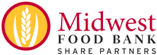

Document ID: 122
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image consists of three main parts. The largest text, "CHARITY NAVIGATOR," is placed at the top in a large, bold, sans-serif font, which suggests it is the name of the organization. The middle text, "Four Star Charity," is in a smaller, bold, sans-serif font, indicating the level of distinction the organization has achieved. The smallest text, "Star," is placed above the "Four Star Charity" text, and it is in a similar font size but in a lighter shade of blue, which may be used to provide a visual distinction from the main text. The text is aligned to the left, and the overall design is simple and professional, likely intended to convey a message of excellence and trustworthiness in the charitable sector.
Image:


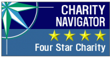

Document ID: 123
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image reads "midw," which stands for "midwife." This text is located in the lower right corner of the image. It is not part of the warehouse scene but appears to be superimposed on the image, likely for branding or informational purposes. It is important to note that the text does not seem to be directly related to the content of the warehouse, which is focused on storage and logistics. The text "midw" does not provide any additional context within the image, so its purpose remains speculative without further information.
Image:


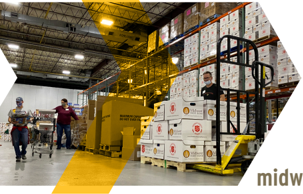

Document ID: 124
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially visible and reads as follows: "FOOD & DISASTER RELIEF". This text suggests that the truck is being used for disaster relief purposes, specifically for distributing food. The presence of the text, along with the image of the person handing out food, implies that the truck is part of a logistical effort to provide aid in a disaster-stricken area. The text is clear and legible, making it a key element of the message being conveyed in the image.
Image:


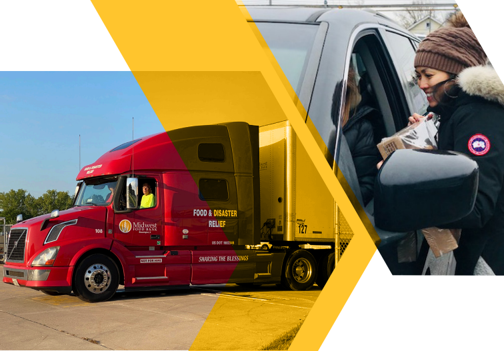

Document ID: 125
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not entirely legible. However, it appears to be part of a larger text that is likely related to the organization mentioned on the man's t-shirt. The visible text on the shirt reads "TEAM RUBICON" and "MASTER RESOURCE." The full text could be part of a slogan or a statement about the organization's purpose or mission. Without a clearer view or additional context, it is not possible to provide a full transcription or interpretation of the text.
Image:


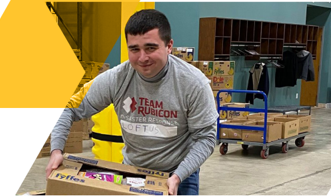

Document ID: 126
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is the name of the organization, "Midwest Food Bank." This text is part of the logo, which is designed to be simple and easily recognizable. The text is in all capital letters, which is a common design choice for logos to ensure readability from a distance. The use of a web address, "MidwestFoodBank.org," suggests that the organization has an online presence, which is typical for non-profit organizations to provide more information and resources to their audience.
Image:


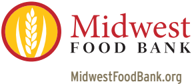

In [40]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

# Although the image processing failed due to rate limits, this loop will attempt to display any existing picture documents.
# If there are no successfully processed picture documents, this loop will simply not print anything.
for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity

## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [41]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

The vector database will be saved to /tmp/vectorstore_s3c6pwxt.db


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [42]:
import itertools

documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")

126 documents added to the vector database


## Step 4: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

In [35]:
query = "How much was spent on food distribution relative to the amount of food distributed?"
for doc in vector_db.as_retriever().invoke(query):
    print(doc)
    print("=" * 80)  # Separator for clarity

page_content='Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)' metadata={'pk': 462683667515834382, 'doc_id': 15, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/texts/141'}
page_content='We  receive  donated  food  from  all  over  the country  -  food  produced  in  excess,  incorrect labeling,  and  more.  Donated  food  comes  from various sources:
- Food manufacturers
- Food distribution centers
- USDA programs
- Grocery stores
- Private food drives' metadata={'pk': 462683667515834410, 'doc_id': 43, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/texts/271 #/texts/272 #/texts/273 #/texts/274 #/texts/275 #/texts/276'}
page_content='Provide industry-leading food relief to those in need while feeding them spiritually.
NOUN
the state of being without reliable access to a sufficient quantity of affordable, nutritious food
Food-insecure households have difficulty at some time during t

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


In [36]:
from ibm_granite_community.langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate

# Create a Granite prompt for question-answering with the retrieved context
prompt_template = ChatPromptTemplate.from_template("{input}")

# Assemble the retrieval-augmented generation chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(),
    combine_docs_chain=combine_docs_chain,
)

### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

In [37]:
from ibm_granite_community.notebook_utils import wrap_text

output = rag_chain.invoke({"input": query})

print(wrap_text(output['answer']))

Based on the provided context, there is no specific information given about the
amount spent on food distribution relative to the amount of food distributed.
The context mentions the value of food distributed in millions, but does not
provide any details about the costs associated with the distribution. Therefore,
the question "How much was spent on food distribution relative to the amount of
food distributed?" cannot be answered with the information given in the context.
Additional information about the costs and expenses related to the food
distribution would be needed to answer this question.


Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!